In [1]:
%%capture
pip install ultralytics

In [3]:
import torch, ultralytics
#!/usr/bin/env python3
import os, sys, json, random, shutil
from pathlib import Path
import re
import cv2
import numpy as np
from skimage.measure import label, regionprops
from ultralytics import YOLO
from pathlib import Path
import shutil
from typing import Tuple, Dict, List
from PIL import Image
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image, ImageDraw
import cv2

from pathlib import Path
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import shutil
from google.colab import drive
import random

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# root
ROOT = Path("../") 
#ROOT = Path("/content/drive/MyDrive/ErdosFall25/")

In [ ]:
from pathlib import Path

def _first_child_startswith(parent: Path, prefix: str, exclude_prefixes=()):
    """Return the first subdir whose name starts with `prefix` (case-insensitive) and
       does NOT start with any of the `exclude_prefixes`."""
    pref = prefix.lower()
    exclude = tuple(ep.lower() for ep in exclude_prefixes)
    for p in sorted(parent.iterdir()):
        if p.is_dir():
            name = p.name.lower()
            if name.startswith(pref) and not any(name.startswith(ep) for ep in exclude):
                return p
    return None

def build_sources_dict_from_schema(split_root: Path):
    """
    Build a dict of {name: {type, images_dir, bbox_dir}} for a split folder.

    - 'single' → top-level images/ (+ bbox/ if exists)
    - 'seqXX'  → seq with images_* and bbox_* (ignoring masks_* and bbox_image_*)
                  -> type='seq_pos' if bbox_* exists, else 'seq_neg'
    - 'seqXX_neg' → negatives: images directly under seq folder, no bbox (type='seq_neg')
    """
    out = {}

    # 1) Top-level single set
    images_dir = split_root / "images_single"
    bbox_dir   = split_root / "bbox"
    if images_dir.exists():
        out["single"] = {
            "type": "single",
            "images_dir": images_dir,
            "bbox_dir": bbox_dir if bbox_dir.exists() else None
        }

    # 2) Sequences (train/valid/test have seq/; test may have seq_test/)
    seq_root = None
    for cand in ("seq", "seq_test"):
        cand_path = split_root / cand
        if cand_path.exists():
            seq_root = cand_path
            break

    if seq_root:
        for seq_dir in sorted([p for p in seq_root.iterdir() if p.is_dir()]):
            name = seq_dir.name
            is_neg = name.lower().endswith("_neg")

            if is_neg:
                # negatives: images directly live in seq_dir; no bbox
                out[name] = {
                    "type": "seq_neg",
                    "images_dir": seq_dir,
                    "bbox_dir": None
                }
            else:
                # positives: look for images_* and bbox_*; ignore masks_* and bbox_image_*
                images_sub = _first_child_startswith(seq_dir, "images")
                # for bbox, exclude 'bbox_image_*'
                bbox_sub   = _first_child_startswith(seq_dir, "bbox", exclude_prefixes=("bbox_image",))

                if images_sub and images_sub.exists():
                    out[name] = {
                        "type": "seq_pos" if (bbox_sub and bbox_sub.exists()) else "seq_neg",
                        "images_dir": images_sub,
                        "bbox_dir": bbox_sub if (bbox_sub and bbox_sub.exists()) else None
                    }
                else:
                    # fallback: treat as negative if no images_* folder
                    out[name] = {
                        "type": "seq_neg",
                        "images_dir": seq_dir,
                        "bbox_dir": None
                    }

    return out

# in google drive use this
ROOT=Path("/content/drive/MyDrive/ErdosFall25/")
#ROOT = Path("../")
train_sources = build_sources_dict_from_schema(ROOT / "data/detection/train")
valid_sources = build_sources_dict_from_schema(ROOT / "data/detection/valid")
test_sources  = build_sources_dict_from_schema(ROOT / "data/detection/test")

print(f"[{ROOT.name}] {len(train_sources)} sources")
for k, v in train_sources.items():
    print(f"  {k}: type={v['type']}"
          f", images_dir={v['images_dir'].relative_to(ROOT)}"
          f", bbox_dir={(v['bbox_dir'].relative_to(ROOT) if v['bbox_dir'] else None)}")


[ErdosFall25] 23 sources
  single: type=single, images_dir=data/detection/train/images_single, bbox_dir=data/detection/train/bbox
  seq10: type=seq_pos, images_dir=data/detection/train/seq/seq10/images_seq10, bbox_dir=data/detection/train/seq/seq10/bbox_seq10
  seq11: type=seq_pos, images_dir=data/detection/train/seq/seq11/images_seq11, bbox_dir=data/detection/train/seq/seq11/bbox_seq11
  seq12: type=seq_pos, images_dir=data/detection/train/seq/seq12/images_seq12, bbox_dir=data/detection/train/seq/seq12/bbox_seq12
  seq13: type=seq_pos, images_dir=data/detection/train/seq/seq13/images_seq13, bbox_dir=data/detection/train/seq/seq13/bbox_seq13
  seq16_neg: type=seq_neg, images_dir=data/detection/train/seq/seq16_neg, bbox_dir=None
  seq1_neg: type=seq_neg, images_dir=data/detection/train/seq/seq1_neg, bbox_dir=None
  seq2: type=seq_pos, images_dir=data/detection/train/seq/seq2/images_seq2, bbox_dir=data/detection/train/seq/seq2/bbox_seq2
  seq22_neg: type=seq_neg, images_dir=data/detectio

### Generate YOLO Labels

In [ ]:
from pathlib import Path
import shutil
import numpy as np
import cv2

# --------- utilities ---------
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def list_images(images_dir: Path):
    return sorted([p for p in images_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])

def parse_bbox_txt(txt_path: Path):
    """
    Lines like: 'polyp 773 760 1056 904' or '773 760 1056 904'
    Returns: boxes (N,4) xyxy in absolute px, labels (N,) ints (0=polyp)
    """
    boxes, labels = [], []
    if not txt_path or not txt_path.exists():
        return np.zeros((0,4), dtype=np.float32), np.zeros((0,), dtype=np.int64)
    with txt_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if parts[0].isalpha():
                parts = parts[1:]
            if len(parts) < 4:
                continue
            x1, y1, x2, y2 = map(float, parts[:4])
            boxes.append([x1, y1, x2, y2])
            labels.append(0)
    if not boxes:
        return np.zeros((0,4), dtype=np.float32), np.zeros((0,), dtype=np.int64)
    return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64)

def clamp_boxes_xyxy(boxes, w, h):
    if boxes.size == 0:
        return boxes
    b = boxes.copy()
    b[:, 0] = np.clip(b[:, 0], 0, w - 1)
    b[:, 1] = np.clip(b[:, 1], 0, h - 1)
    b[:, 2] = np.clip(b[:, 2], 0, w - 1)
    b[:, 3] = np.clip(b[:, 3], 0, h - 1)
    b[:, [0,2]] = np.sort(b[:, [0,2]], axis=1)
    b[:, [1,3]] = np.sort(b[:, [1,3]], axis=1)
    keep = (b[:, 2] > b[:, 0]) & (b[:, 3] > b[:, 1])
    return b[keep]

def xyxy_to_yolo(boxes_xyxy, w, h):
    if boxes_xyxy.size == 0:
        return np.zeros((0, 4), dtype=np.float32)
    x1, y1, x2, y2 = boxes_xyxy[:, 0], boxes_xyxy[:, 1], boxes_xyxy[:, 2], boxes_xyxy[:, 3]
    bw = (x2 - x1)
    bh = (y2 - y1)
    cx = x1 + bw / 2.0
    cy = y1 + bh / 2.0
    return np.stack([cx / w, cy / h, bw / w, bh / h], axis=1).astype(np.float32)

def write_yolo_label_file(label_path: Path, yolo_rows):
    label_path.parent.mkdir(parents=True, exist_ok=True)
    with label_path.open("w") as f:
        for cls_id, (cx, cy, bw, bh) in yolo_rows:
            f.write(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

def index_txts_one_dir(bbox_dir: Path):
    """Index ONLY this directory (no recursion): stem -> txt path."""
    idx = {}
    if bbox_dir and bbox_dir.exists():
        for p in sorted(bbox_dir.iterdir()):
            if p.is_file() and p.suffix.lower() == ".txt":
                idx[p.stem] = p
    return idx

def find_label_for_stem(stem: str, idx: dict):
    if stem in idx:
        return idx[stem]
    for suf in ("_mask", "_bbox", "_label", "_polyp"):
        s = stem + suf
        if s in idx:
            return idx[s]
    return None

# Make a unique flat filename to avoid collisions between sources
def make_dest_names(source_key: str, img_path: Path):
    stem = f"{source_key}__{img_path.stem}"
    return stem, img_path.suffix.lower()

# --------- core builder ---------
def build_yolo_from_sources(
    sources_dict: dict,
    split_root: Path,
    selection_fn=None,
    verbose=True
):
    """
    Build YOLO-ready folders for a split from a sources dict produced earlier.

    - sources_dict: { name: {"type": "single"/"seq_pos"/"seq_neg", "images_dir": Path, "bbox_dir": Optional[Path]} }
    - split_root:   e.g., ROOT / "data/detection/train"
    - selection_fn(source_key: str, images: list[Path]) -> list[Path]
        If None: keep all images. You can pass a function to subsample frames per source.

    Writes:
      split_root/images_all/*.jpg|png...
      split_root/labels/*.txt
    """
    images_out = split_root / "images"
    labels_out = split_root / "labels"
    images_out.mkdir(parents=True, exist_ok=True)
    labels_out.mkdir(parents=True, exist_ok=True)

    total = pos = neg = bad = 0

    for source_key, meta in sources_dict.items():
        img_dir = meta["images_dir"]
        bbox_dir = meta.get("bbox_dir")
        source_type = meta["type"]

        imgs = list_images(img_dir)
        if selection_fn is not None:
            imgs = selection_fn(source_key, imgs)

        # Index labels ONLY for this source (if present)
        lbl_index = index_txts_one_dir(bbox_dir) if bbox_dir else {}

        for img_path in imgs:
            # load image size
            im = cv2.imread(str(img_path))
            if im is None:
                bad += 1
                continue
            h, w = im.shape[:2]

            # resolve label for this image inside this source only
            lbl_path = find_label_for_stem(img_path.stem, lbl_index) if lbl_index else None

            boxes_xyxy, labels = parse_bbox_txt(lbl_path)
            boxes_xyxy = clamp_boxes_xyxy(boxes_xyxy, w, h)
            yolo_boxes = xyxy_to_yolo(boxes_xyxy, w, h)
            rows = [(int(c), wh) for c, wh in zip(labels.tolist(), yolo_boxes)]

            # copy image + write label
            dest_stem, ext = make_dest_names(source_key, img_path)
            dest_img = images_out / f"{dest_stem}{ext}"
            if not dest_img.exists():
                shutil.copy2(img_path, dest_img)

            dest_lbl = labels_out / f"{dest_stem}.txt"
            write_yolo_label_file(dest_lbl, rows)

            total += 1
            if len(rows) > 0:
                pos += 1
            else:
                neg += 1

        if verbose:
            print(f"[{split_root.name}:{source_key}] imgs={len(imgs)}  with_labels={pos}  neg={neg}  bad={bad}")

    if verbose:
        print(f"\n[{split_root.name}] TOTAL={total}  POS={pos}  NEG={neg}  BAD={bad}")
        print(f"images_out = {images_out}")
        print(f"labels_out = {labels_out}")



# Example selection rule: keep ALL images (change later to subsample)
def keep_all(_, imgs): return imgs

build_yolo_from_sources(train_sources, ROOT / "data/detection/train", selection_fn=keep_all)
build_yolo_from_sources(valid_sources, ROOT / "data/detection/valid", selection_fn=keep_all)
if (ROOT / "data/detection/test").exists():
    build_yolo_from_sources(test_sources,  ROOT / "data/detection/test",  selection_fn=keep_all)

# After this, data.yaml should look like:
# path: ../data/detection
# train: train/images
# val: valid/images
# test: test/images
# names: {0: polyp}


[train:single] imgs=1105  with_labels=1013  neg=92  bad=0
[train:seq10] imgs=25  with_labels=1020  neg=110  bad=0
[train:seq11] imgs=228  with_labels=1156  neg=202  bad=0
[train:seq12] imgs=250  with_labels=1406  neg=202  bad=0
[train:seq13] imgs=250  with_labels=1605  neg=253  bad=0
[train:seq16_neg] imgs=141  with_labels=1605  neg=394  bad=0
[train:seq1_neg] imgs=315  with_labels=1605  neg=709  bad=0
[train:seq2] imgs=63  with_labels=1665  neg=712  bad=0
[train:seq22_neg] imgs=82  with_labels=1665  neg=794  bad=0
[train:seq2_neg] imgs=302  with_labels=1665  neg=1096  bad=0
[train:seq3] imgs=15  with_labels=1680  neg=1096  bad=0
[train:seq3_neg] imgs=40  with_labels=1680  neg=1136  bad=0
[train:seq4] imgs=48  with_labels=1726  neg=1138  bad=0
[train:seq4_neg] imgs=72  with_labels=1726  neg=1210  bad=0
[train:seq5] imgs=250  with_labels=1925  neg=1261  bad=0
[train:seq5_neg] imgs=61  with_labels=1925  neg=1322  bad=0
[train:seq6] imgs=91  with_labels=1987  neg=1351  bad=0
[train:seq6_n

In [ ]:
def check_split(split):
    root = Path(ROOT/"data/detection")/split
    imgs = {p.stem for p in (root/"images").glob("*.*")}
    lbls = {p.stem for p in (root/"labels").glob("*.txt")}
    print(f"[{split}] images={len(imgs)}  labels={len(lbls)}")
    print("  missing labels for images:", len(imgs - lbls))
    print("  orphan labels:", len(lbls - imgs))

for s in ["train","valid","test"]:
    if (Path(ROOT/"data/detection")/s).exists():
        check_split(s)

### Generate Mask RCNN Format Data

In [3]:
%%capture
!pip install torch torchvision albumentations pycocotools opencv-python



In [5]:
import json, os, math, time, random
from pathlib import Path

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import box_iou, nms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Fix the seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
from pathlib import Path
import json
from PIL import Image

def yolo_to_coco(images_dir, labels_dir, out_json, class_name="polyp"):
    """
    Convert YOLO .txt (class cx cy w h normalized) -> COCO JSON (for detection).
    """
    images, annotations = [], []
    categories = [{"id": 1, "name": class_name}]
    ann_id, img_id = 1, 1

    images_dir, labels_dir = Path(images_dir), Path(labels_dir)
    img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

    for img_path in sorted(images_dir.rglob("*")):
        if img_path.suffix.lower() not in img_exts:
            continue
        W, H = Image.open(img_path).size
        images.append({
            "id": img_id,
            "file_name": str(img_path.resolve()),
            "width": W,
            "height": H
        })

        label_file = labels_dir / f"{img_path.stem}.txt"
        if label_file.exists():
            with open(label_file) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls, xc, yc, w, h = map(float, parts)
                    x = (xc - w/2) * W
                    y = (yc - h/2) * H
                    w *= W
                    h *= H
                    annotations.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 1,
                        "bbox": [x, y, w, h],
                        "area": float(w * h),
                        "iscrowd": 0
                    })
                    ann_id += 1
        img_id += 1

    coco = {"images": images, "annotations": annotations, "categories": categories}
    out_json = Path(out_json)
    out_json.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json, "w") as f:
        json.dump(coco, f)
    print(f"Wrote {out_json} ({len(images)} images, {len(annotations)} boxes).")


In [7]:
# train json
yolo_to_coco(ROOT/"data/detection/train/images", ROOT/"data/detection/train/labels", ROOT/"data/detection/train/annotations.json")


Wrote ..\data\detection\train\annotations.json (4169 images, 2232 boxes).


In [8]:
# valid json
yolo_to_coco(ROOT/"data/detection/valid/images", ROOT/"data/detection/valid/labels", ROOT/"data/detection/valid/annotations.json")

Wrote ..\data\detection\valid\annotations.json (666 images, 375 boxes).


## Baseline Model

In [9]:
from pathlib import Path
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [10]:
TRAIN_JSON = ROOT / "data" / "detection" / "train" / "annotations.json"
VAL_JSON   = ROOT / "data" / "detection" / "valid" / "annotations.json"
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2, numpy as np, json, torch
from torch.utils.data import Dataset

class CocoBoxDataset(Dataset):
    def __init__(self, ann_json, resize_max=896, do_aug=True):
        with open(ann_json) as f:
            coco = json.load(f)
        self.images = coco["images"]
        self.anns   = coco["annotations"]
        self.anns_by_img = {}
        for a in self.anns:
            self.anns_by_img.setdefault(a["image_id"], []).append(a)

        base = [
            A.LongestMaxSize(max_size=resize_max, p=1.0),
            A.PadIfNeeded(resize_max, resize_max, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
            A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255.0),  # -> float32 [0,1]
            ToTensorV2(),
        ]
        if do_aug:
            self.tfm = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(0.1, 0.1, p=0.4),
                A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.08, rotate_limit=12,
                                   border_mode=cv2.BORDER_CONSTANT, value=0, p=0.7),
            ] + base, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        else:
            self.tfm = A.Compose(base, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    def __len__(self): return len(self.images)

    def __getitem__(self, i):
        im = self.images[i]
        img = cv2.imread(im["file_name"])
        if img is None:
            raise FileNotFoundError(im["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]

        # build COCO→Pascal VOC boxes
        boxes, labels = [], []
        for a in self.anns_by_img.get(im["id"], []):
            x, y, w, h = a["bbox"]
            x1, y1, x2, y2 = x, y, x + w, y + h
            boxes.append([x1, y1, x2, y2])
            labels.append(a.get("category_id", 1))

        boxes  = np.asarray(boxes,  dtype=np.float32) if len(boxes)  > 0 else np.zeros((0,4), np.float32)
        labels = np.asarray(labels, dtype=np.int64)   if len(labels) > 0 else np.zeros((0,),  np.int64)

        # sanitize BEFORE Albumentations to avoid tiny negatives / out-of-bounds
        if len(boxes) > 0:
            # clip to [0, W] / [0, H]
            boxes[:, 0] = np.clip(boxes[:, 0], 0, W)  # x1
            boxes[:, 1] = np.clip(boxes[:, 1], 0, H)  # y1
            boxes[:, 2] = np.clip(boxes[:, 2], 0, W)  # x2
            boxes[:, 3] = np.clip(boxes[:, 3], 0, H)  # y2
            # drop degenerate / inverted boxes after clipping
            eps = 1e-6
            keep = (boxes[:, 2] - boxes[:, 0] > eps) & (boxes[:, 3] - boxes[:, 1] > eps)
            boxes, labels = boxes[keep], labels[keep]

        out = self.tfm(image=img, bboxes=boxes, labels=labels)

        bxs, lbs = out["bboxes"], out["labels"]
        boxes  = np.asarray(bxs, dtype=np.float32) if len(bxs) > 0 else np.zeros((0,4), np.float32)
        labels = np.asarray(lbs, dtype=np.int64)   if len(lbs) > 0 else np.zeros((0,),  np.int64)

        target = {
            "boxes":  torch.as_tensor(boxes,  dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([im["id"]], dtype=torch.int64),
        }
        return out["image"], target




In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [13]:
from torch.utils.data import DataLoader

train_ds = CocoBoxDataset(TRAIN_JSON, do_aug=True)
val_ds   = CocoBoxDataset(VAL_JSON,   do_aug=False)

def collate_fn(b): return tuple(zip(*b))

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)


C:\Users\Betul\AppData\Local\Temp\ipykernel_18360\4155467321.py:18: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(resize_max, resize_max, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
c:\Users\Betul\Desktop\Projects\Polyp\polyp_env\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Betul\AppData\Local\Temp\ipykernel_18360\4155467321.py:26: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.08, rotate_limit=12,


Showing random TRAIN images with boxes...


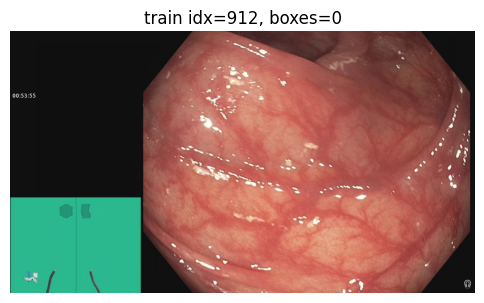

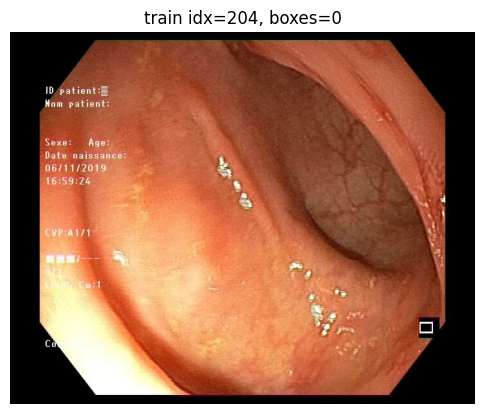

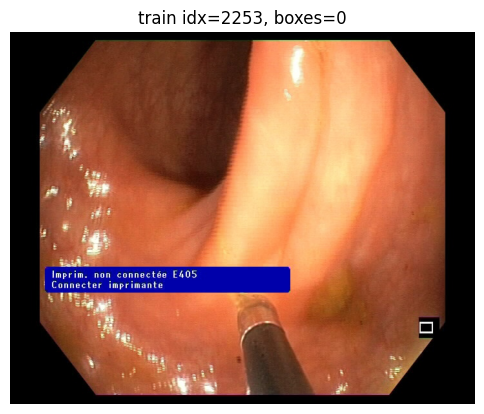

Showing random VALID images with boxes...


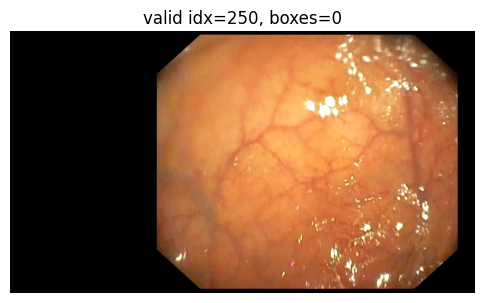

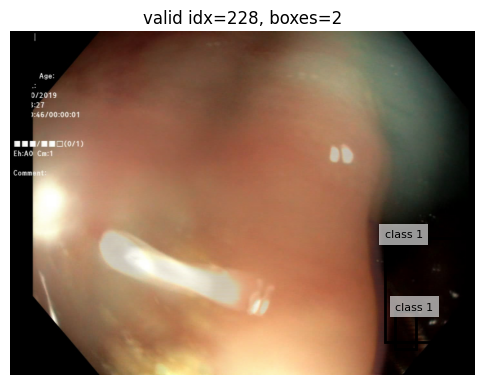

In [14]:
# --- COCO box visualization (no extra deps) ---
import json, random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def load_coco_json(ann_json_path):
    with open(ann_json_path) as f:
        coco = json.load(f)
    images = coco["images"]
    anns_by_img = {}
    for a in coco["annotations"]:
        anns_by_img.setdefault(a["image_id"], []).append(a)
    return images, anns_by_img

def show_random_from_coco(ann_json_path, count=3, title_prefix=""):
    images, anns_by_img = load_coco_json(ann_json_path)
    n = len(images)
    if n == 0:
        print(f"No images in {ann_json_path}")
        return
    idxs = random.sample(range(n), k=min(count, n))
    for i in idxs:
        im_info = images[i]
        img_path = im_info["file_name"]
        img = cv2.imread(img_path)
        if img is None:
            print(f"[warn] Could not read: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        ax = plt.gca()

        for a in anns_by_img.get(im_info["id"], []):
            x, y, w, h = a["bbox"]
            rect = Rectangle((x, y), w, h, fill=False, linewidth=2)
            ax.add_patch(rect)
            lab = a.get("category_id", 1)
            ax.text(x, max(0,y-3), f"class {lab}", fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        ax.set_axis_off()
        plt.title(f"{title_prefix} idx={i}, boxes={len(anns_by_img.get(im_info['id'], []))}")
        plt.show()

print("Showing random TRAIN images with boxes...")
show_random_from_coco(TRAIN_JSON, count=3, title_prefix="train")

print("Showing random VALID images with boxes...")
show_random_from_coco(VAL_JSON, count=2, title_prefix="valid")


In [15]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# a) load COCO-pretrained model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# b) replace detection head (num_classes = background + polyp = 2)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes=2)

# c) (transfer learning) freeze backbone params → only train the head
for p in model.backbone.parameters():
    p.requires_grad = False

model = model.to(DEVICE)

In [16]:
# train only trainable params (the head)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # optional


In [17]:
imgs, targets = next(iter(train_loader))
print(imgs[0].dtype, imgs[0].min().item(), imgs[0].max().item())  # expect torch.float32 ~ 0.0..1.0


torch.float32 0.0 1.0


In [18]:
import math, time

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running = 0.0
    for imgs, targets in loader:
        imgs = [im.to(device) for im in imgs]
        targets = [{k:(v.to(device) if torch.is_tensor(v) else v) for k,v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += float(loss.item())
    return running/len(loader)

num_epochs = 10
best_recall = -1
best_path = ROOT / "models"
best_path.mkdir(parents=True, exist_ok=True)
ckpt_path = best_path / "fasterrcnn_polyp_head.pt"

for epoch in range(1, num_epochs+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    scheduler.step()

    # quick validation (recall @ IoU 0.5, conf >= 0.5)
    model.eval()
    tp=fp=fn=0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [im.to(DEVICE) for im in imgs]
            outputs = model(imgs)
            preds = outputs[0]
            gt = targets[0]
            # thresholds
            keep = preds["scores"] >= 0.5
            pboxes = preds["boxes"][keep].cpu()
            gboxes = gt["boxes"].cpu()

            if len(gboxes)==0:
                fp += len(pboxes)
                continue
            if len(pboxes)==0:
                fn += len(gboxes)
                continue

            # IoU matching (greedy)
            from torchvision.ops import box_iou
            ious = box_iou(pboxes, gboxes)
            matched_pred = set()
            matched_gt = set()
            for _ in range(min(len(pboxes), len(gboxes))):
                i, j = divmod(ious.argmax().item(), ious.shape[1])
                if ious[i, j] < 0.5: break
                if i not in matched_pred and j not in matched_gt:
                    matched_pred.add(i); matched_gt.add(j)
                ious[i, :] = -1; ious[:, j] = -1
            tp += len(matched_pred)
            fp += (len(pboxes) - len(matched_pred))
            fn += (len(gboxes) - len(matched_gt))

    recall = tp / (tp + fn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | val R@0.5={recall:.3f} P@0.5={precision:.3f}")

    if recall > best_recall:
        best_recall = recall
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ✓ saved best checkpoint → {ckpt_path.name}")


Epoch 01 | train loss 0.1070 | val R@0.5=0.456 P@0.5=0.251
  ✓ saved best checkpoint → fasterrcnn_polyp_head.pt
Epoch 02 | train loss 0.0845 | val R@0.5=0.523 P@0.5=0.215
  ✓ saved best checkpoint → fasterrcnn_polyp_head.pt
Epoch 03 | train loss 0.0843 | val R@0.5=0.443 P@0.5=0.472
Epoch 04 | train loss 0.0782 | val R@0.5=0.467 P@0.5=0.376
Epoch 05 | train loss 0.0771 | val R@0.5=0.515 P@0.5=0.299
Epoch 06 | train loss 0.0694 | val R@0.5=0.525 P@0.5=0.303
  ✓ saved best checkpoint → fasterrcnn_polyp_head.pt
Epoch 07 | train loss 0.0705 | val R@0.5=0.531 P@0.5=0.281
  ✓ saved best checkpoint → fasterrcnn_polyp_head.pt
Epoch 08 | train loss 0.0679 | val R@0.5=0.472 P@0.5=0.363
Epoch 09 | train loss 0.0652 | val R@0.5=0.496 P@0.5=0.360
Epoch 10 | train loss 0.0623 | val R@0.5=0.475 P@0.5=0.322


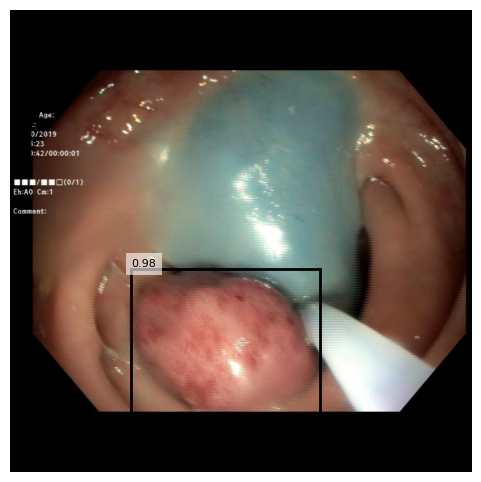

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

model.eval()
with torch.no_grad():
    imgs, targets = next(iter(val_loader))
    img = imgs[0].to(DEVICE)
    out = model([img])[0]
    im_np = (img.permute(1,2,0).cpu().numpy()*255).clip(0,255).astype("uint8")

plt.figure(figsize=(6,6))
plt.imshow(im_np)
ax = plt.gca()
for (x1,y1,x2,y2), s in zip(out["boxes"].cpu(), out["scores"].cpu()):
    if s < 0.5: continue
    ax.add_patch(Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
    ax.text(x1, max(0,y1-3), f"{s:.2f}", fontsize=8, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
ax.set_axis_off()
plt.show()
